In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("/content/drive/MyDrive/Store sales forcasting/train.csv")

In [3]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [5]:
df.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


## Here date column is currently in text,so cnverting it into proper date time formate so we can plot it.




In [6]:
df['date']=pd.to_datetime(df['date'])

##Sum up all sales from all stores for each day to get a single, total sales number for each date.

In [7]:
daily_Sales=df.groupby('date')['sales'].sum().reset_index ()

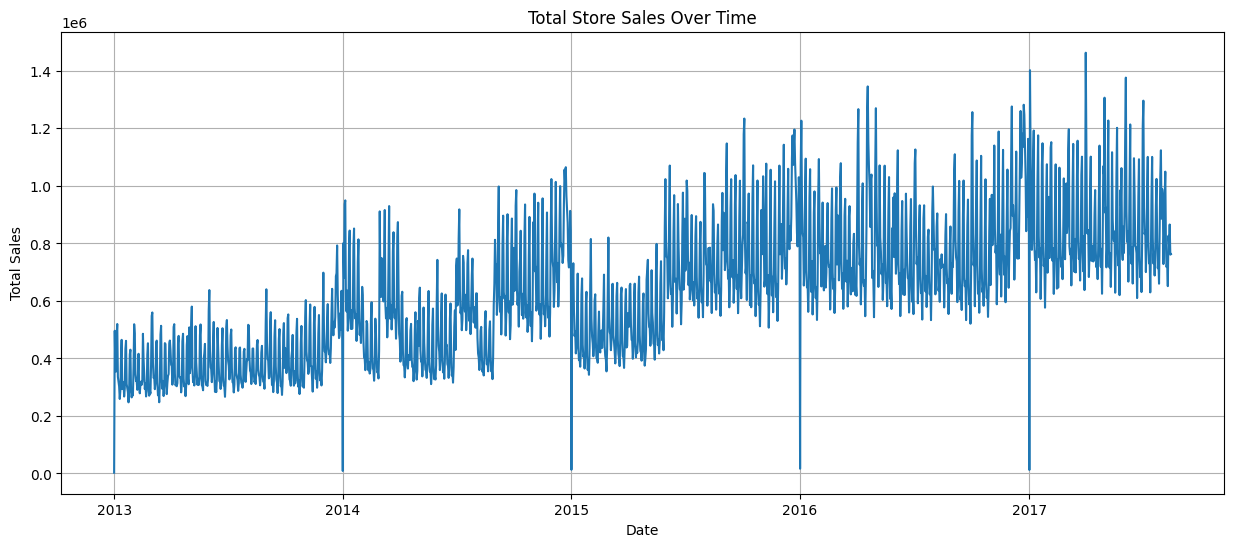

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='sales', data=daily_Sales)
plt.title('Total Store Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

## ploting weakly and monthly sales over year.

In [9]:
df['day_of_week'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month_name()

In [10]:
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]


/tmp/ipython-input-1299140173.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


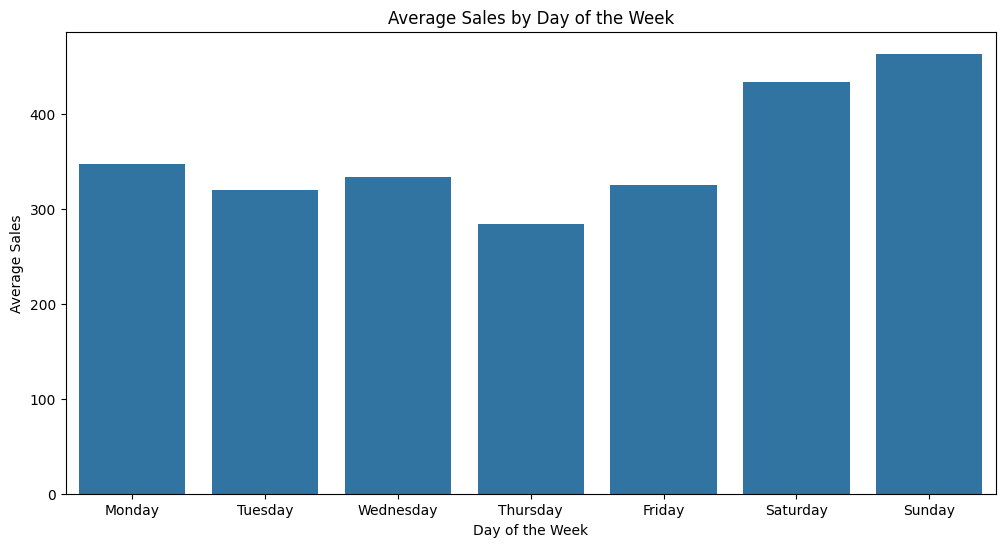

In [11]:
# --- Plot 1: Average Sales by Day of Week ---
plt.figure(figsize=(12, 6))
sns.barplot(
    x='day_of_week',
    y='sales',
    data=df,
    order=weekday_order,
    ci=None # Hides the error bars for a cleaner look
)
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.show()

/tmp/ipython-input-4251008896.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


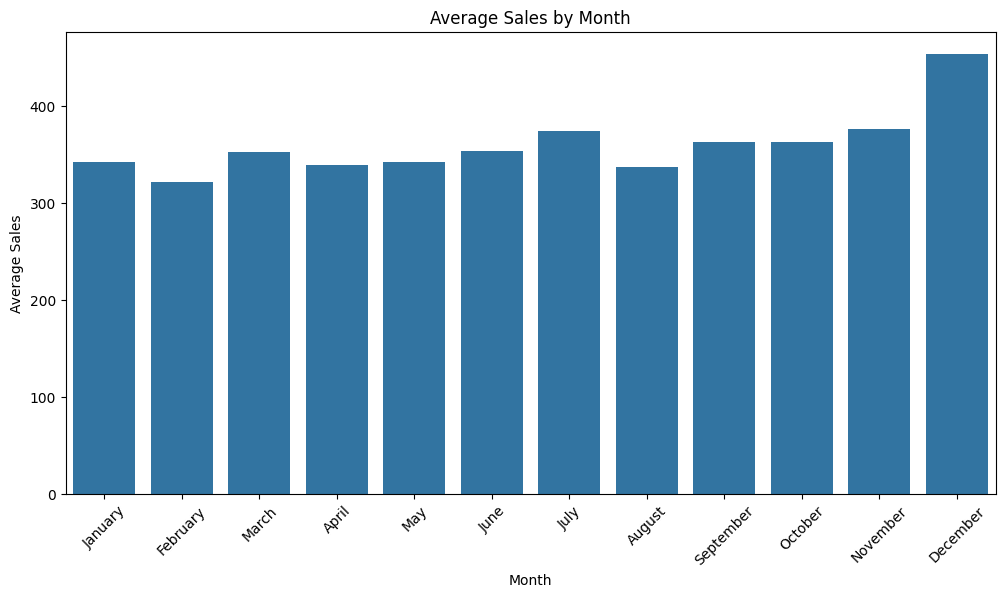

In [12]:
# --- Plot 2: Average Sales by Month ---
plt.figure(figsize=(12, 6))
sns.barplot(
    x='month',
    y='sales',
    data=df,
    order=month_order,
    ci=None
)
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=45) # Rotate month names for better readability
plt.show()

In [13]:
# --- Create a unique identifier for each time series ---
df['id'] = df['store_nbr'].astype(str) + '_' + df['family']


In [14]:
# --- Pivot the DataFrame to have dates as index and series as columns ---
df_pivot = df.pivot(index='date', columns='id', values='sales')

In [15]:
# --- Create lag and rolling features ---
# This calculates the 7-day rolling mean for each series and then shifts it by 16 days
# The 16-day shift is crucial to prevent data leakage from the target period
rolling_mean_7 = df_pivot.rolling(window=7).mean().shift(16)

In [16]:
# --- Unpivot the data back to its original format ---
df_lags = rolling_mean_7.unstack().reset_index()
df_lags = df_lags.rename(columns={0: 'sales_rolling_mean_7'})
df_lags['date'] = df_lags['date'].astype('datetime64[ns]')

In [17]:
# --- Merge the new features back into your main DataFrame ---
# Ensure your main DataFrame is ready for this merge
# This should be done before you drop columns or create dummies
df = pd.merge(df, df_lags, on=['id', 'date'], how='left')

## meargeing all other files to create one csv file.

In [18]:
stores_df = pd.read_csv("/content/drive/MyDrive/Store sales forcasting/stores.csv")
oil_df = pd.read_csv("/content/drive/MyDrive/Store sales forcasting/oil.csv")
holidays_df = pd.read_csv("/content/drive/MyDrive/Store sales forcasting/holidays_events.csv")
transactions_df=pd.read_csv("/content/drive/MyDrive/Store sales forcasting/transactions.csv")



In [19]:
# --- Convert date columns to datetime objects for merging ---
oil_df['date'] = pd.to_datetime(oil_df['date'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])
transactions_df['date'] = pd.to_datetime(transactions_df['date'])


In [20]:
## mearge with store
df=pd.merge(df,stores_df,on='store_nbr',how='left')

In [21]:
# merge with oil
df=pd.merge(df,oil_df,on='date',how='left')

In [22]:
## merge with holidays
df=pd.merge(df,holidays_df,on='date',how='left')

In [23]:
# Merge transaction counts using both 'date' and 'store_nbr'
df = pd.merge(df, transactions_df, on=['date', 'store_nbr'], how='left')

In [24]:
print("Shape of the new DataFrame:",df.shape)
print(df.head())

Shape of the new DataFrame: (3054348, 20)
             id       date  store_nbr      family  sales  onpromotion  \
0  1_AUTOMOTIVE 2013-01-01          1  AUTOMOTIVE    0.0            0   
1   1_BABY CARE 2013-01-01          1   BABY CARE    0.0            0   
2      1_BEAUTY 2013-01-01          1      BEAUTY    0.0            0   
3   1_BEVERAGES 2013-01-01          1   BEVERAGES    0.0            0   
4       1_BOOKS 2013-01-01          1       BOOKS    0.0            0   

  day_of_week    month  sales_rolling_mean_7   city      state type_x  \
0     Tuesday  January                   NaN  Quito  Pichincha      D   
1     Tuesday  January                   NaN  Quito  Pichincha      D   
2     Tuesday  January                   NaN  Quito  Pichincha      D   
3     Tuesday  January                   NaN  Quito  Pichincha      D   
4     Tuesday  January                   NaN  Quito  Pichincha      D   

   cluster  dcoilwtico   type_y    locale locale_name         description  \
0  

## Feature Engineering

> Add blockquote



In [26]:
# Extracting time-related features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek # Monday=0, Sunday=6
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)

In [27]:
# Feature for payday effect (15th and end of month)
df['is_payday'] = df['date'].dt.is_month_end | (df['date'].dt.day == 15)
df['is_payday'] = df['is_payday'].astype(int)

In [28]:
# 'ffill' stands for 'forward fill for filling missing values in oil column'
df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill')

/tmp/ipython-input-603234156.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill')


In [29]:
# Create a simple binary feature for whether a day is a holiday/event or not.
df['is_holiday'] = (df['type_y'] != 'NormalDay').astype(int)


In [30]:
# --- Display the DataFrame with new features ---
print("DataFrame with new features:")
# We select a few key columns to see the changes clearly
print(df[['date', 'year', 'month', 'day', 'is_payday', 'dcoilwtico', 'is_holiday']].head())
print(df.info())


DataFrame with new features:
        date  year  month  day  is_payday  dcoilwtico  is_holiday
0 2013-01-01  2013      1    1          0         NaN           1
1 2013-01-01  2013      1    1          0         NaN           1
2 2013-01-01  2013      1    1          0         NaN           1
3 2013-01-01  2013      1    1          0         NaN           1
4 2013-01-01  2013      1    1          0         NaN           1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 25 columns):
 #   Column                Dtype         
---  ------                -----         
 0   id                    object        
 1   date                  datetime64[ns]
 2   store_nbr             int64         
 3   family                object        
 4   sales                 float64       
 5   onpromotion           int64         
 6   day_of_week           int32         
 7   month                 int32         
 8   sales_rolling_mean_7  float64       


## one hot encoding

In [31]:
# We are selecting a few important ones to keep the model simple for now
categorical_cols = ['family', 'city', 'state', 'type_x']

In [32]:
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [33]:
print("Shape of the new encoded DataFrame:",df_encoded.shape)


Shape of the new encoded DataFrame: (3054348, 93)


In [34]:
df_encoded.head()

,id,date,store_nbr,sales,onpromotion,day_of_week,month,sales_rolling_mean_7,cluster,dcoilwtico,...,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,type_x_B,type_x_C,type_x_D,type_x_E
0,1_AUTOMOTIVE,2013-01-01,1,0.0,0,1,1,NaN,13,NaN,...,False,False,True,False,False,False,False,False,True,False
1,1_BABY CARE,2013-01-01,1,0.0,0,1,1,NaN,13,NaN,...,False,False,True,False,False,False,False,False,True,False
2,1_BEAUTY,2013-01-01,1,0.0,0,1,1,NaN,13,NaN,...,False,False,True,False,False,False,False,False,True,False
3,1_BEVERAGES,2013-01-01,1,0.0,0,1,1,NaN,13,NaN,...,False,False,True,False,False,False,False,False,True,False
4,1_BOOKS,2013-01-01,1,0.0,0,1,1,NaN,13,NaN,...,False,False,True,False,False,False,False,False,True,False


In [35]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 93 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   id                                    object        
 1   date                                  datetime64[ns]
 2   store_nbr                             int64         
 3   sales                                 float64       
 4   onpromotion                           int64         
 5   day_of_week                           int32         
 6   month                                 int32         
 7   sales_rolling_mean_7                  float64       
 8   cluster                               int64         
 9   dcoilwtico                            float64       
 10  type_y                                object        
 11  locale                                object        
 12  locale_name                           object        
 13  description 

In [36]:
# --- Define the target variable ---
y =df_encoded['sales']

In [37]:
features_to_drop = [
    'id',
    'date',
    'sales',
    'type_y',
    'locale',
    'locale_name',
    'description',
    'transferred'
]

In [38]:
X = df.drop(columns=features_to_drop)


In [39]:
import numpy as np

X = X.select_dtypes(include=np.number)


In [43]:
print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)
print("\nFirst 5 rows of your final features (X):")
print(X.tail())

Features (X) shape: (3054348, 13)
Target (y) shape: (3054348,)

First 5 rows of your final features (X):
         store_nbr  onpromotion  day_of_week  month  sales_rolling_mean_7  \
3054343          9            0            1      8            379.960146   
3054344          9            1            1      8             93.605286   
3054345          9          148            1      8           1518.658571   
3054346          9            8            1      8             11.857143   
3054347          9            0            1      8             15.545714   

         cluster  dcoilwtico  transactions  year  day  week_of_year  \
3054343        6       47.57        2155.0  2017   15            33   
3054344        6       47.57        2155.0  2017   15            33   
3054345        6       47.57        2155.0  2017   15            33   
3054346        6       47.57        2155.0  2017   15            33   
3054347        6       47.57        2155.0  2017   15            33   

     

## Training a Base line model using LightGBM

In [45]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import numpy as np
!pip install optuna
import optuna


In [46]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [47]:
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2443478, 13)
Validation data shape: (610870, 13)


In [48]:
params = {
    'objective': 'regression_l1',
    'metric': 'rmse',
    'n_estimators': 1000,
    'learning_rate': 0.1,   # fixed value
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 64,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}

# Initialize model
model = lgb.LGBMRegressor(**params)

# Train the model
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(50)]
)

# Make predictions
preds = model.predict(X_val)
preds[preds < 0] = 0

# Evaluate RMSLE
rmsle = np.sqrt(mean_squared_log_error(y_val, preds))
print(f'Validation RMSLE: {rmsle:.4f}')

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 303.744
Validation RMSLE: 0.7305
